In [ ]:
from pathlib import Path

from utils import (
    read_excel_2cols_per_ticker,
    ticker_start_summary,
    build_and_save_harmonized_wides,
)

# Note: PairSelectionConfig et select_pairs_from_wide_excel seront définis plus bas
# ou importés depuis un module à créer

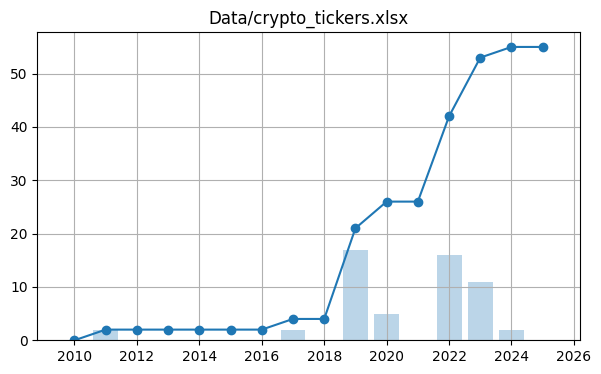

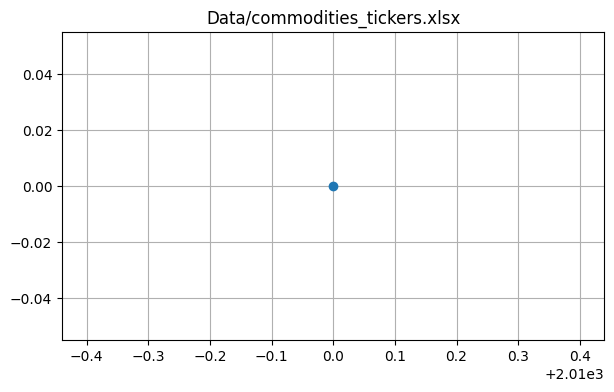

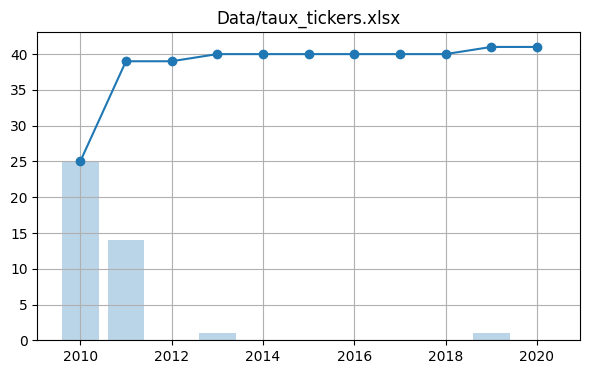

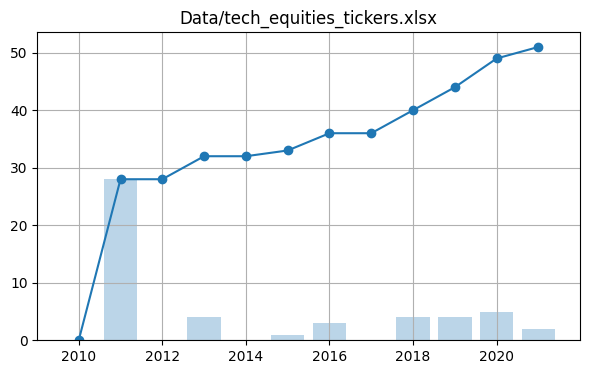

In [3]:
files = [
    "Data/crypto_tickers.xlsx",
    "Data/commodities_tickers.xlsx",
    "Data/taux_tickers.xlsx",
    "Data/tech_equities_tickers.xlsx",
]

for f in files:
    series = read_excel_2cols_per_ticker(f)
    ticker_start_summary(series, plot=True, title=f)


In [4]:
input_files = {
    "crypto": "Data/crypto_tickers.xlsx",
    "commodities": "Data/commodities_tickers.xlsx",
    "taux": "Data/taux_tickers.xlsx",
    "tech": "Data/tech_equities_tickers.xlsx",
}

build_and_save_harmonized_wides_from_start(input_files)


{'crypto':             XBT Curncy  XET Curncy  XRP Curncy  XBN Curncy  XMR Curncy  \
 2019-01-01     3720.60     137.740      0.3558      159.50      47.835   
 2019-01-02     3884.98     154.550      0.3720      168.40      52.753   
 2019-01-03     3794.92     147.973      0.3545      162.57      50.107   
 2019-01-04     3833.53     154.140      0.3567      161.65      51.966   
 2019-01-05     3833.53     154.140      0.3567      161.65      51.966   
 ...                ...         ...         ...         ...         ...   
 2025-12-27    87601.51    2933.442      1.8613      619.44     455.285   
 2025-12-28    87518.71    2936.165      1.8612      618.42     451.990   
 2025-12-29    87216.14    2933.775      1.8520      597.09     439.160   
 2025-12-30    88185.04    2965.995      1.8715      593.30     440.315   
 2025-12-31    87647.54    2977.695      1.8391      600.10     435.115   
 
             XLM Curncy  XZC Curncy  XLC Curncy  XTH Curncy  XVC Curncy  ...  \
 2019-01

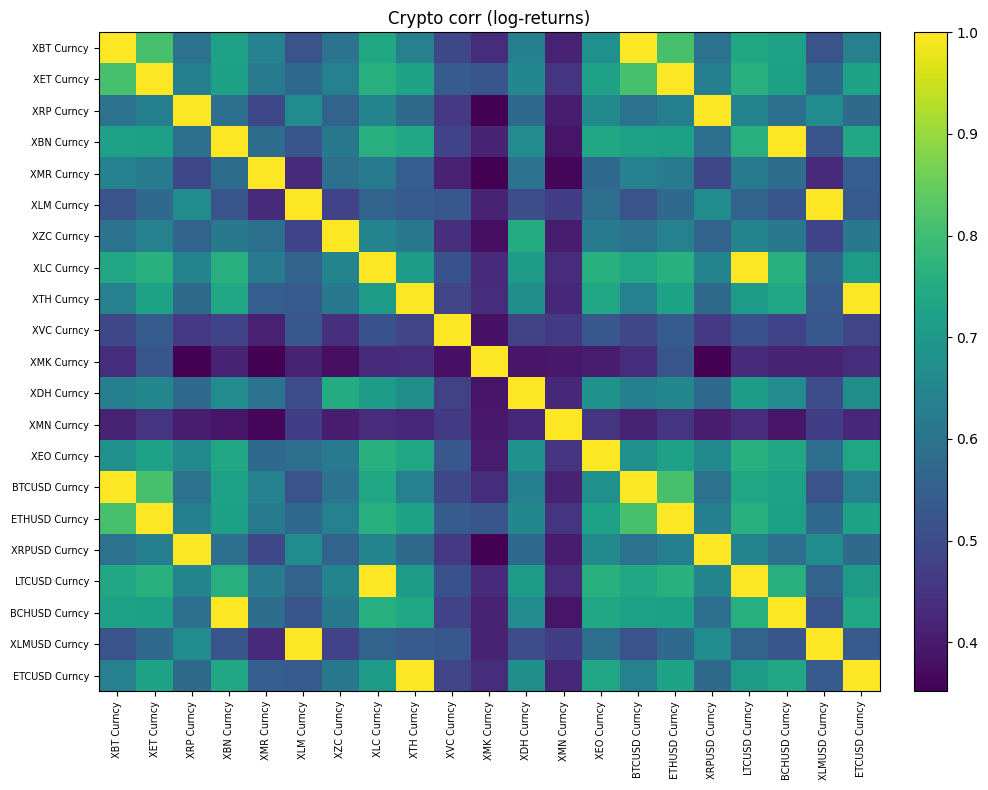

Dropped: ['BCHUSD Curncy', 'BTCUSD Curncy', 'ETCUSD Curncy', 'ETHUSD Curncy', 'LTCUSD Curncy', 'XLMUSD Curncy', 'XRPUSD Curncy']


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


crypto: 3 pairs saved


/usr/local/python/3.12.1/lib/python3.12/site-packages/pandas/core/internals/blocks.py:347: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


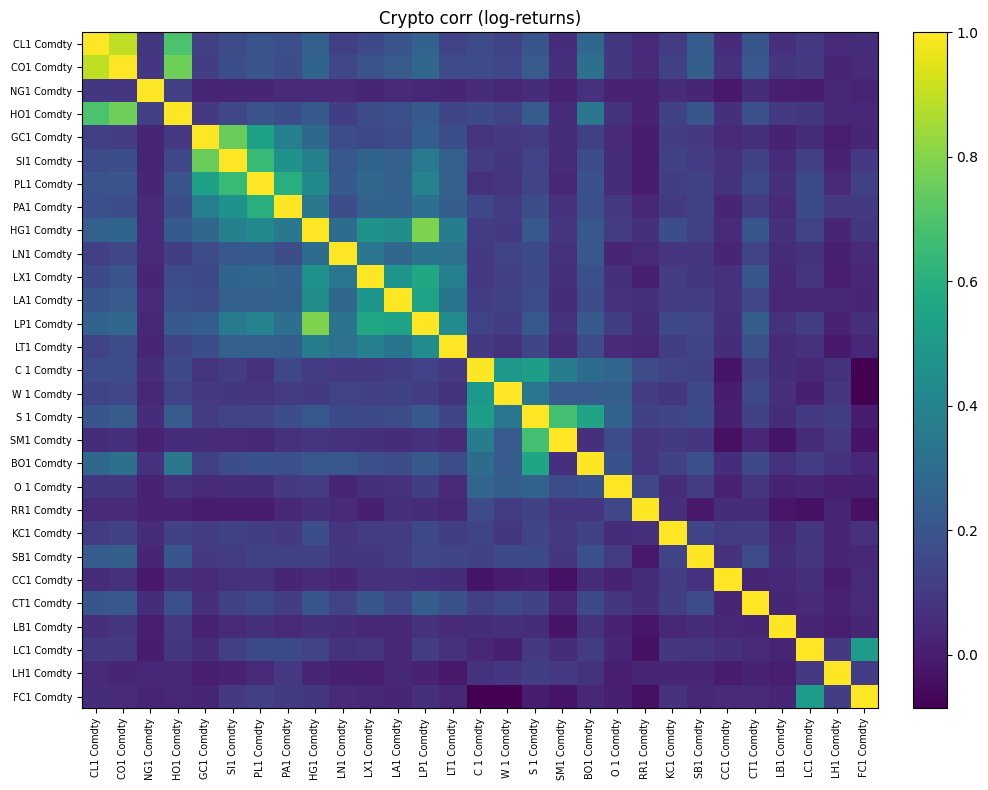

Dropped: []


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


commodities: 3 pairs saved


/usr/local/python/3.12.1/lib/python3.12/site-packages/pandas/core/internals/blocks.py:347: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/python/3.12.1/lib/python3.12/site-packages/pandas/core/internals/blocks.py:347: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


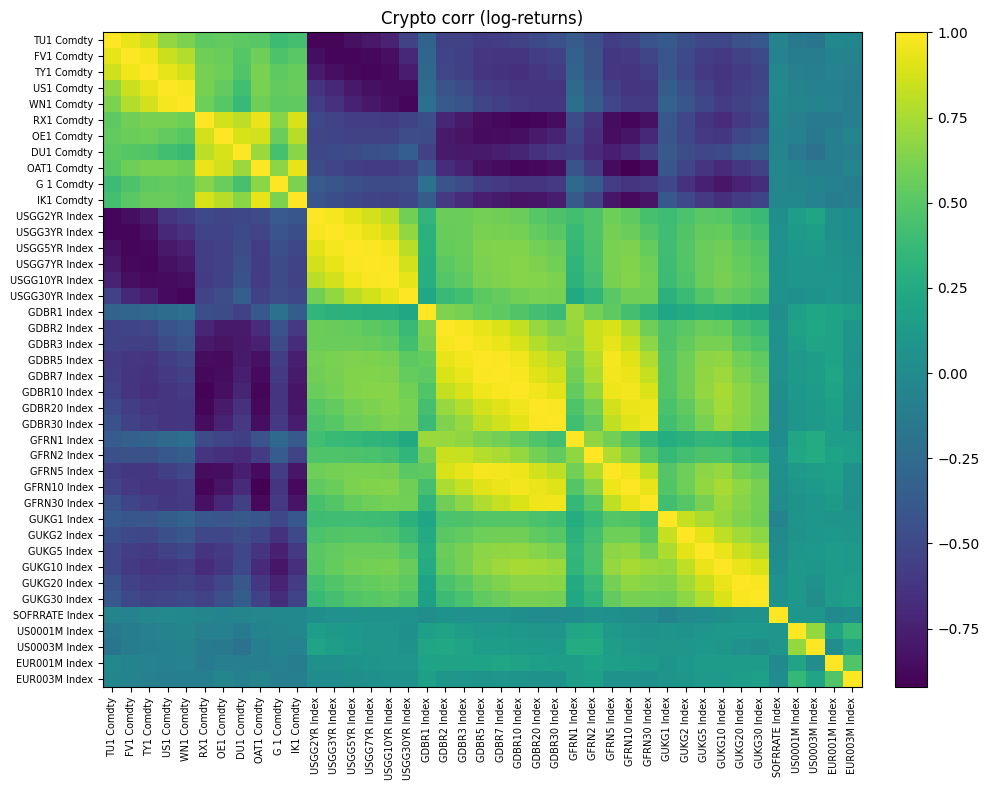

Dropped: []


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


taux: 3 pairs saved


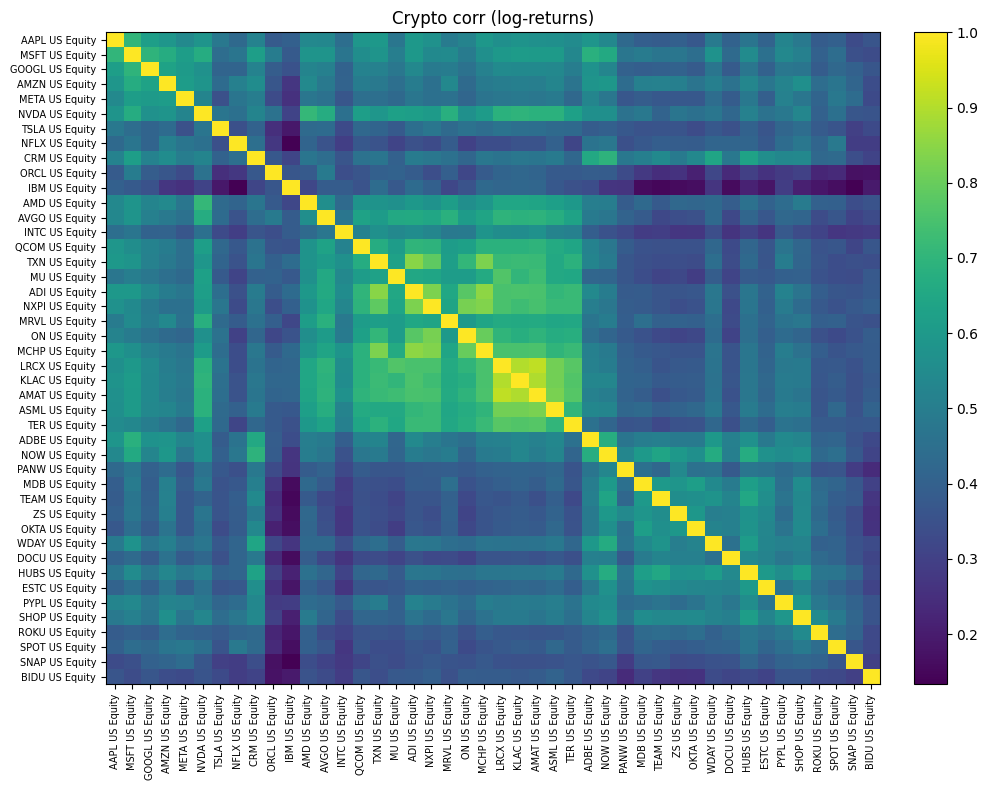

Dropped: []


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


tech: 3 pairs saved


In [5]:
base = Path("Data")

files = {
    "crypto": base / "crypto_2019_wide_harmonized.xlsx",
    "commodities": base / "commodities_2019_wide_harmonized.xlsx",
    "taux": base / "taux_2019_wide_harmonized.xlsx",
    "tech": base / "tech_2019_wide_harmonized.xlsx",
}

base_cfg = PairSelectionConfig(
    k_min=2,
    k_max=10,
    mds_dim=5,
    alpha=0.05,
    min_obs=252,
    series_kind="log_price",
    normalize_for_dtw="zscore",
    dropna_how="inner",
    use_tslearn=True,
    cache=True,                    # ✅ FAST
    cache_dir="Data/.cache_pairs", # ✅ FAST
)

pairs_by_class = {}

for name, path in files.items():
    cfg = replace(base_cfg, alpha=0.15) if name == "crypto" else base_cfg

    df = pd.read_excel(path, index_col="Date", parse_dates=True)
    df_filtered, corr, dropped = drop_highly_correlated_columns(
    df,
    k=0.9995,
    method="logret",
    plot=True,
    title="Crypto corr (log-returns)"
)

    print("Dropped:", dropped)
    pairs = select_pairs_from_wide_df(df_filtered, cfg=cfg, top_k=3, method="greedy")

    pairs_by_class[name] = pairs
    pairs.to_csv(base / f"pairs_{name}.csv", index=False)

    print(f"{name}: {len(pairs)} pairs saved")


---

## 📝 Pour adapter aux autres classes d'actifs

Il suffit de changer la variable `ASSET_CLASS`:

```python
# Pour commodities
ASSET_CLASS = "commodities"

# Pour taux (govies)
ASSET_CLASS = "govies"

# Pour tech equities
ASSET_CLASS = "tech"
```

Assurez-vous que les fichiers suivants existent dans `Data/`:
- `pairs_{ASSET_CLASS}.csv`
- `{ASSET_CLASS}_2019_wide_harmonized.xlsx`

# 🎯 Zhang Paper Analysis - Multi-Asset Pairs Trading Backtest

Analyse in-sample / out-of-sample pour **4 classes d'actifs** avec **3 paires chacune**:
- **In-sample**: 2019-01-01 → 2023-12-31
- **Out-of-sample**: 2024-01-01 → 2025-12-31

Application: crypto, commodities, taux, tech equities - avec **Numba** pour accélération.

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict
from pathlib import Path
import time
import warnings

warnings.filterwarnings("ignore")

try:
    from numba import njit
    NUMBA_AVAILABLE = True
    print("✅ Numba disponible - calculs accélérés")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠️  Numba non disponible - utilisation NumPy")
    def njit(*args, **kwargs):
        def decorator(func):
            return func
        if len(args) == 1 and callable(args[0]):
            return args[0]
        return decorator


In [ ]:
@njit(cache=True)
def halton_sequence_njit(size: int, base: int) -> np.ndarray:
    sequence = np.zeros(size)
    for i in range(size):
        n = i + 1
        f, result = 1.0, 0.0
        while n > 0:
            f = f / base
            result = result + f * (n % base)
            n = n // base
        sequence[i] = result
    return sequence


@njit(cache=True)
def kalman_filter_njit(y: np.ndarray, theta0: float, theta1: float,
                       q: float, r: float) -> Tuple[float, np.ndarray]:
    n = len(y)

    if abs(theta1) < 0.999:
        x = theta0 / (1.0 - theta1)
        P = q / (1.0 - theta1 * theta1)
    else:
        x = y[0]
        P = q * 10.0

    x_filt = np.zeros(n)
    loglik = 0.0
    log_2pi = np.log(2.0 * np.pi)

    for t in range(n):
        if t > 0:
            x = theta0 + theta1 * x
            P = theta1 * theta1 * P + q

        v = y[t] - x
        S = P + r

        if S > 1e-12:
            K = P / S
            x = x + K * v
            P = (1.0 - K) * P
            loglik += -0.5 * (log_2pi + np.log(S) + v * v / S)

        x_filt[t] = x

    return loglik, x_filt


@njit(cache=True)
def qmckf_njit(y: np.ndarray, theta0: float, theta1: float,
               q_base: float, q_het: float, r: float,
               n_particles: int) -> Tuple[float, np.ndarray]:
    n = len(y)
    x = y[0]
    P = q_base + q_het * x * x

    x_filt = np.zeros(n)
    loglik = 0.0
    log_2pi = np.log(2.0 * np.pi)

    h1 = halton_sequence_njit(n_particles, 2)
    h2 = halton_sequence_njit(n_particles, 3)

    for i in range(n_particles):
        h1[i] = max(1e-10, min(1.0 - 1e-10, h1[i]))
        h2[i] = max(1e-10, min(1.0 - 1e-10, h2[i]))

    z = np.zeros(n_particles)
    for i in range(n_particles):
        z[i] = np.sqrt(-2.0 * np.log(h1[i])) * np.cos(2.0 * np.pi * h2[i])

    samples = np.zeros(n_particles)
    f_samples = np.zeros(n_particles)

    for t in range(n):
        if t == 0:
            x_p, P_p = x, P
        else:
            sqrt_P = np.sqrt(max(P, 1e-12))
            sum_f = 0.0
            for i in range(n_particles):
                samples[i] = x + sqrt_P * z[i]
                f_samples[i] = theta0 + theta1 * samples[i]
                sum_f += f_samples[i]
            x_p = sum_f / n_particles

            sum_var, sum_g = 0.0, 0.0
            for i in range(n_particles):
                diff = f_samples[i] - x_p
                sum_var += diff * diff
                sum_g += q_base + q_het * samples[i] * samples[i]
            P_p = sum_var / n_particles + sum_g / n_particles

        v = y[t] - x_p
        S = P_p + r

        if S > 1e-12:
            K = P_p / S
            x = x_p + K * v
            P = (1.0 - K) * P_p
            loglik += -0.5 * (log_2pi + np.log(S) + v * v / S)
        else:
            x, P = x_p, P_p

        x_filt[t] = x

    return loglik, x_filt


@njit(cache=True)
def strategy_A_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: float) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(n):
        if pos == 0:
            if x[t] >= U[t]:
                pos = -1
            elif x[t] <= L[t]:
                pos = 1
        elif pos == 1 and x[t] >= C:
            pos = 0
        elif pos == -1 and x[t] <= C:
            pos = 0
        sig[t] = pos

    return sig


@njit(cache=True)
def strategy_C_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: float) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(1, n):
        prev, curr = x[t - 1], x[t]
        U_prev, U_curr = U[t - 1], U[t]
        L_prev, L_curr = L[t - 1], L[t]

        entry_short = (prev > U_prev) and (curr <= U_curr)
        entry_long = (prev < L_prev) and (curr >= L_curr)
        exit_long = (prev < C) and (curr >= C)
        exit_short = (prev > C) and (curr <= C)
        stop_short = (prev < U_prev) and (curr >= U_curr)
        stop_long = (prev > L_prev) and (curr <= L_curr)

        if pos == 0:
            if entry_short:
                pos = -1
            elif entry_long:
                pos = 1
        elif pos == 1 and (exit_long or stop_long):
            pos = 0
        elif pos == -1 and (exit_short or stop_short):
            pos = 0

        sig[t] = pos

    return sig


@njit(cache=True)
def backtest_njit(signals: np.ndarray, x_filt: np.ndarray, cost_bp: float) -> Tuple[float, float, int]:
    n = len(signals)
    pnl = np.zeros(n)

    n_trades = 0
    cost_factor = 2.0 * cost_bp / 10000.0

    for t in range(1, n):
        dx = x_filt[t] - x_filt[t - 1]
        pos_change = abs(signals[t] - signals[t - 1])
        if pos_change > 0:
            n_trades += 1
        pnl[t] = signals[t] * dx - pos_change * cost_factor

    cum_pnl = np.sum(pnl)
    ann_ret = cum_pnl / (n / 252.0)

    std_pnl = np.std(pnl)
    ann_std = std_pnl * np.sqrt(252.0)

    sharpe = (ann_ret - 0.02) / ann_std if ann_std > 1e-12 else 0.0
    return ann_ret, sharpe, n_trades

print("✅ Core functions OK")


In [ ]:
@njit(cache=True)
def grid_search_select_nstd_is_njit(
    x_filt_is,
    q_base,
    q_het,
    is_hetero,
    use_strategy_C,
    cost_bp
):
    best_n = 1.0
    best_ret = -1e10
    best_sr = -1e10
    best_trades = 0

    for i in range(25):
        n_std = 0.1 + 0.1 * i

        # seuils calculés sur IS (OK)
        U, L, C = compute_thresholds_is_static_njit(x_filt_is, q_base, q_het, n_std, is_hetero)

        sig = strategy_C_njit(x_filt_is, U, L, C) if use_strategy_C else strategy_A_njit(x_filt_is, U, L, C)
        ann_ret, sharpe, n_trades = backtest_njit(sig, x_filt_is, cost_bp)

        if n_trades > 0 and sharpe > best_sr:
            best_sr = sharpe
            best_ret = ann_ret
            best_n = n_std
            best_trades = n_trades

    return best_n, best_ret, best_sr, best_trades


In [ ]:
@njit(cache=True)
def compute_thresholds_is_static_njit(x_filt: np.ndarray, q_base: float, q_het: float,
                                      n_std: float, is_hetero: bool) -> Tuple[np.ndarray, np.ndarray, float]:
    n = len(x_filt)
    C = np.mean(x_filt)
    sigma_emp = np.std(x_filt)

    U = np.zeros(n)
    L = np.zeros(n)

    if is_hetero and q_het > 1e-10:
        g_x = np.sqrt(q_base + q_het * x_filt * x_filt)
        mean_g = np.mean(g_x)
        for t in range(n):
            sigma_t = g_x[t] / mean_g * sigma_emp
            U[t] = C + n_std * sigma_t
            L[t] = C - n_std * sigma_t
    else:
        thr = n_std * sigma_emp
        for t in range(n):
            U[t] = C + thr
            L[t] = C - thr

    return U, L, C


In [ ]:
@njit(cache=True)
def compute_thresholds_oos_expanding_njit(
    x_filt_is,         # historique IS (pour init expanding)
    x_filt_oos,        # série OOS à trader
    q_base,
    q_het,
    n_std,
    is_hetero
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Renvoie U_oos, L_oos, C_oos (C = mean expanding).
    Expanding sans look-ahead:
      - stats(t) = stats sur [IS + OOS[:t]] (donc jusqu'à t-1 pour décisions à t)
    """
    n_is = len(x_filt_is)
    n_oos = len(x_filt_oos)

    U = np.zeros(n_oos)
    L = np.zeros(n_oos)
    C = np.zeros(n_oos)

    # Running mean/var (Welford) initialisés sur IS
    mean = 0.0
    M2 = 0.0
    count = 0

    for i in range(n_is):
        count += 1
        delta = x_filt_is[i] - mean
        mean += delta / count
        delta2 = x_filt_is[i] - mean
        M2 += delta * delta2

    # Running mean_g si hetero
    mean_g = 1.0
    if is_hetero and q_het > 1e-12:
        gsum = 0.0
        for i in range(n_is):
            gsum += np.sqrt(q_base + q_het * x_filt_is[i] * x_filt_is[i])
        mean_g = gsum / n_is

    for t in range(n_oos):
        # std basée sur historique dispo AVANT d'utiliser x_filt_oos[t]
        var = (M2 / count) if count > 1 else 1e-12
        std = np.sqrt(max(var, 1e-12))

        C[t] = mean

        if is_hetero and q_het > 1e-12:
            gx = np.sqrt(q_base + q_het * x_filt_oos[t] * x_filt_oos[t])
            sigma_t = gx / mean_g * std
            U[t] = mean + n_std * sigma_t
            L[t] = mean - n_std * sigma_t
        else:
            thr = n_std * std
            U[t] = mean + thr
            L[t] = mean - thr

        # UPDATE stats avec observation courante (pour t+1)
        xnew = x_filt_oos[t]
        count += 1
        delta = xnew - mean
        mean += delta / count
        delta2 = xnew - mean
        M2 += delta * delta2

    return U, L, C

print("✅ IS grid + OOS expanding thresholds OK")


In [ ]:
@dataclass
class ModelParams:
    theta0: float = 0.0
    theta1: float = 0.95
    q_base: float = 1e-4
    q_het: float = 0.0
    r: float = 1e-4


def estimate_gamma_ols(log_PA: np.ndarray, log_PB: np.ndarray) -> float:
    X = np.column_stack([np.ones(len(log_PB)), log_PB])
    return float(np.linalg.lstsq(X, log_PA, rcond=None)[0][1])


def estimate_model_I(y: np.ndarray) -> Tuple[ModelParams, np.ndarray, float]:
    y_mean, y_var = np.mean(y), np.var(y)
    rho = np.corrcoef(y[:-1] - y_mean, y[1:] - y_mean)[0, 1]
    theta1_init = float(np.clip(rho, 0.8, 0.99))

    z0 = np.array([
        y_mean * (1 - theta1_init),
        np.arctanh(theta1_init),
        np.log(y_var * (1 - theta1_init ** 2) * 0.7 + 1e-10),
        np.log(y_var * 0.3 + 1e-10),
    ])

    def neg_ll(z):
        ll, _ = kalman_filter_njit(y, z[0], np.tanh(z[1]), np.exp(z[2]), np.exp(z[3]))
        return -ll if np.isfinite(ll) else 1e10

    bounds = [(-0.5, 0.5),
              (np.arctanh(0.5), np.arctanh(0.999)),
              (np.log(1e-8), np.log(1.0)),
              (np.log(1e-8), np.log(1.0))]

    res = minimize(neg_ll, z0, method='L-BFGS-B', bounds=bounds)

    params = ModelParams(
        theta0=float(res.x[0]),
        theta1=float(np.tanh(res.x[1])),
        q_base=float(np.exp(res.x[2])),
        r=float(np.exp(res.x[3])),
        q_het=0.0
    )

    ll, x_filt = kalman_filter_njit(y, params.theta0, params.theta1, params.q_base, params.r)
    return params, x_filt, float(ll)


def estimate_model_II(y: np.ndarray) -> Tuple[ModelParams, np.ndarray, float]:
    y_mean = float(np.mean(y))
    best_ll, best_params, best_filt = -np.inf, None, None

    for t0, t1, q_b, q_h, r in [
        (y_mean * 0.01, 0.95, 0.0005, 0.10, 0.010),
        (y_mean * 0.01, 0.93, 0.0003, 0.13, 0.011),
        (y_mean * 0.01, 0.96, 0.0010, 0.08, 0.008),
    ]:
        z0 = np.array([t0, np.arctanh(t1), np.log(q_b), np.log(q_h), np.log(r)])

        def neg_ll(z):
            ll, _ = qmckf_njit(y, z[0], np.tanh(z[1]), np.exp(z[2]), np.exp(z[3]), np.exp(z[4]), 50)
            return -ll if np.isfinite(ll) else 1e10

        bounds = [(-0.1, 0.1),
                  (np.arctanh(0.85), np.arctanh(0.99)),
                  (np.log(1e-6), np.log(0.005)),
                  (np.log(0.05), np.log(0.3)),
                  (np.log(0.005), np.log(0.05))]

        try:
            res = minimize(neg_ll, z0, method='L-BFGS-B', bounds=bounds, options={'maxiter': 500})
            params = ModelParams(
                theta0=float(res.x[0]),
                theta1=float(np.tanh(res.x[1])),
                q_base=float(np.exp(res.x[2])),
                q_het=float(np.exp(res.x[3])),
                r=float(np.exp(res.x[4]))
            )
            ll, x_filt = qmckf_njit(y, params.theta0, params.theta1, params.q_base, params.q_het, params.r, 100)
            if ll > best_ll:
                best_ll, best_params, best_filt = float(ll), params, x_filt
        except Exception:
            continue

    if best_params is None:
        best_params = ModelParams(theta0=0.0, theta1=0.95, q_base=0.0003, q_het=0.1, r=0.01)
        ll, x_filt = qmckf_njit(y, best_params.theta0, best_params.theta1,
                                best_params.q_base, best_params.q_het, best_params.r, 100)
        best_ll, best_filt = float(ll), x_filt

    return best_params, best_filt, float(best_ll)

print("✅ Estimation OK")


In [ ]:
def load_price_data_from_wide_excel(data_path: str, ticker: str) -> pd.Series:
    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)
    if ticker not in df.columns:
        raise ValueError(f"{ticker} not in {data_path}")
    return df[ticker].dropna().sort_index()


def load_pairs_for_all_classes(asset_classes: Dict[str, str], top_k: int = 3) -> Dict[str, pd.DataFrame]:
    pairs_data = {}
    for asset_class in asset_classes.keys():
        pairs_path = Path("Data") / f"pairs_{asset_class}.csv"
        if pairs_path.exists():
            df = pd.read_csv(pairs_path).head(top_k)
            pairs_data[asset_class] = df
            print(f"✅ {asset_class:15s}: {len(df)} paires")
        else:
            print(f"⚠️  {asset_class:15s}: {pairs_path} non trouvé")
            pairs_data[asset_class] = pd.DataFrame()
    return pairs_data


In [ ]:
def analyze_pair_is_oos_clean(
    data_path: str,
    ticker_1: str,
    ticker_2: str,
    is_start: str,
    is_end: str,
    oos_start: str,
    oos_end: str,
    cost_bp: float = 20.0
) -> Tuple[Optional[Dict], Optional[Dict]]:

    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)

    if ticker_1 not in df.columns or ticker_2 not in df.columns:
        return None, None

    PA_full = df[ticker_1].dropna().sort_index()
    PB_full = df[ticker_2].dropna().sort_index()

    common = PA_full.index.intersection(PB_full.index)
    if len(common) < 400:
        return None, None

    PA_full = PA_full.loc[common]
    PB_full = PB_full.loc[common]

    # --- IS slice
    is_mask = (PA_full.index >= pd.Timestamp(is_start)) & (PA_full.index <= pd.Timestamp(is_end))
    PA_is = PA_full.loc[is_mask]
    PB_is = PB_full.loc[is_mask]
    if len(PA_is) < 252:
        return None, None

    log_PA_is = np.log(PA_is.values)
    log_PB_is = np.log(PB_is.values)

    gamma_is = estimate_gamma_ols(log_PA_is, log_PB_is)
    y_is = log_PA_is - gamma_is * log_PB_is

    # Estimation sur IS
    p1_is, f1_is, _ = estimate_model_I(y_is)
    p2_is, f2_is, _ = estimate_model_II(y_is)

    # Grid-search sur IS uniquement (n_std)
    n1_is, ret_m1_is, sr_m1_is, tr_m1_is = grid_search_select_nstd_is_njit(
        f1_is, p1_is.q_base, 0.0, False, False, cost_bp
    )
    n2_is, ret_m2_is, sr_m2_is, tr_m2_is = grid_search_select_nstd_is_njit(
        f2_is, p2_is.q_base, p2_is.q_het, True, True, cost_bp
    )

    result_is = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "gamma_is": float(gamma_is),
        "M1_nstd": float(n1_is), "M1_Return": float(ret_m1_is), "M1_Sharpe": float(sr_m1_is), "M1_Trades": int(tr_m1_is),
        "M2_nstd": float(n2_is), "M2_Return": float(ret_m2_is), "M2_Sharpe": float(sr_m2_is), "M2_Trades": int(tr_m2_is),
        "N_IS": int(len(y_is))
    }

    # --- OOS slice
    oos_mask = (PA_full.index >= pd.Timestamp(oos_start)) & (PA_full.index <= pd.Timestamp(oos_end))
    PA_oos = PA_full.loc[oos_mask]
    PB_oos = PB_full.loc[oos_mask]
    if len(PA_oos) < 100:
        return result_is, None

    log_PA_oos = np.log(PA_oos.values)
    log_PB_oos = np.log(PB_oos.values)
    y_oos = log_PA_oos - gamma_is * log_PB_oos

    # Filtrage OOS avec params IS
    _, f1_oos = kalman_filter_njit(y_oos, p1_is.theta0, p1_is.theta1, p1_is.q_base, p1_is.r)
    _, f2_oos = qmckf_njit(y_oos, p2_is.theta0, p2_is.theta1, p2_is.q_base, p2_is.q_het, p2_is.r, 100)

    # Seuils OOS expanding (warm start IS)
    U1_oos, L1_oos, C1_oos = compute_thresholds_oos_expanding_njit(
        f1_is, f1_oos, p1_is.q_base, 0.0, float(n1_is), False
    )
    U2_oos, L2_oos, C2_oos = compute_thresholds_oos_expanding_njit(
        f2_is, f2_oos, p2_is.q_base, p2_is.q_het, float(n2_is), True
    )

    # Signals OOS (attention: stratégie C utilise t-1/t)
    sig1_oos = strategy_A_njit(f1_oos, U1_oos, L1_oos, C1_oos[0])  # C varie dans le temps, A utilise un C constant normalement
    # 👉 pour rester cohérent, on va trader avec C_t = C1_oos[t]. On fait une version dédiée ci-dessous.

    return result_is, {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "M1_nstd": float(n1_is),
        "M2_nstd": float(n2_is),
        "N_OOS": int(len(y_oos)),
        "NOTE": "OOS computed with expanding stats (no look-ahead). Next cell replaces signal logic to use time-varying C."
    }


In [ ]:
@njit(cache=True)
def strategy_A_timevaryingC_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: np.ndarray) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0
    for t in range(n):
        if pos == 0:
            if x[t] >= U[t]:
                pos = -1
            elif x[t] <= L[t]:
                pos = 1
        elif pos == 1 and x[t] >= C[t]:
            pos = 0
        elif pos == -1 and x[t] <= C[t]:
            pos = 0
        sig[t] = pos
    return sig


@njit(cache=True)
def strategy_C_timevaryingC_njit(x: np.ndarray, U: np.ndarray, L: np.ndarray, C: np.ndarray) -> np.ndarray:
    n = len(x)
    sig = np.zeros(n)
    pos = 0

    for t in range(1, n):
        prev, curr = x[t - 1], x[t]
        U_prev, U_curr = U[t - 1], U[t]
        L_prev, L_curr = L[t - 1], L[t]
        C_prev, C_curr = C[t - 1], C[t]

        entry_short = (prev > U_prev) and (curr <= U_curr)
        entry_long  = (prev < L_prev) and (curr >= L_curr)

        exit_long   = (prev < C_prev) and (curr >= C_curr)
        exit_short  = (prev > C_prev) and (curr <= C_curr)

        stop_short  = (prev < U_prev) and (curr >= U_curr)
        stop_long   = (prev > L_prev) and (curr <= L_curr)

        if pos == 0:
            if entry_short:
                pos = -1
            elif entry_long:
                pos = 1
        elif pos == 1 and (exit_long or stop_long):
            pos = 0
        elif pos == -1 and (exit_short or stop_short):
            pos = 0

        sig[t] = pos

    return sig

print("✅ Strategies with time-varying C OK")


In [ ]:
@njit(cache=True)
def backtest_with_signals_njit(signals: np.ndarray, x: np.ndarray, cost_bp: float) -> Tuple[float, float, int]:
    return backtest_njit(signals, x, cost_bp)


def evaluate_oos_expanding(
    f_is: np.ndarray,
    f_oos: np.ndarray,
    q_base: float,
    q_het: float,
    n_std: float,
    is_hetero: bool,
    use_strategy_C: bool,
    cost_bp: float
) -> Tuple[float, float, int]:

    U, L, C = compute_thresholds_oos_expanding_njit(
        f_is, f_oos, q_base, q_het, n_std, is_hetero
    )

    if use_strategy_C:
        sig = strategy_C_timevaryingC_njit(f_oos, U, L, C)
    else:
        sig = strategy_A_timevaryingC_njit(f_oos, U, L, C)

    return backtest_with_signals_njit(sig, f_oos, cost_bp)


In [ ]:
def analyze_pair_is_oos_FINAL(
    data_path: str,
    ticker_1: str,
    ticker_2: str,
    is_start: str,
    is_end: str,
    oos_start: str,
    oos_end: str,
    cost_bp: float = 20.0
) -> Tuple[Optional[Dict], Optional[Dict]]:

    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)
    if ticker_1 not in df.columns or ticker_2 not in df.columns:
        return None, None

    PA = df[ticker_1].dropna().sort_index()
    PB = df[ticker_2].dropna().sort_index()
    common = PA.index.intersection(PB.index)
    if len(common) < 400:
        return None, None
    PA, PB = PA.loc[common], PB.loc[common]

    # IS
    is_mask = (PA.index >= pd.Timestamp(is_start)) & (PA.index <= pd.Timestamp(is_end))
    PA_is, PB_is = PA.loc[is_mask], PB.loc[is_mask]
    if len(PA_is) < 252:
        return None, None

    log_PA_is = np.log(PA_is.values)
    log_PB_is = np.log(PB_is.values)
    gamma_is = estimate_gamma_ols(log_PA_is, log_PB_is)
    y_is = log_PA_is - gamma_is * log_PB_is

    p1_is, f1_is, _ = estimate_model_I(y_is)
    p2_is, f2_is, _ = estimate_model_II(y_is)

    n1_is, ret1_is, sr1_is, tr1_is = grid_search_select_nstd_is_njit(
        f1_is, p1_is.q_base, 0.0, False, False, cost_bp
    )
    n2_is, ret2_is, sr2_is, tr2_is = grid_search_select_nstd_is_njit(
        f2_is, p2_is.q_base, p2_is.q_het, True, True, cost_bp
    )

    result_is = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "gamma_is": float(gamma_is),
        "M1_nstd": float(n1_is), "M1_Return": float(ret1_is), "M1_Sharpe": float(sr1_is), "M1_Trades": int(tr1_is),
        "M2_nstd": float(n2_is), "M2_Return": float(ret2_is), "M2_Sharpe": float(sr2_is), "M2_Trades": int(tr2_is),
        "N_IS": int(len(y_is))
    }

    # OOS
    oos_mask = (PA.index >= pd.Timestamp(oos_start)) & (PA.index <= pd.Timestamp(oos_end))
    PA_oos, PB_oos = PA.loc[oos_mask], PB.loc[oos_mask]
    if len(PA_oos) < 100:
        return result_is, None

    log_PA_oos = np.log(PA_oos.values)
    log_PB_oos = np.log(PB_oos.values)
    y_oos = log_PA_oos - gamma_is * log_PB_oos

    _, f1_oos = kalman_filter_njit(y_oos, p1_is.theta0, p1_is.theta1, p1_is.q_base, p1_is.r)
    _, f2_oos = qmckf_njit(y_oos, p2_is.theta0, p2_is.theta1, p2_is.q_base, p2_is.q_het, p2_is.r, 100)

    ret1_oos, sr1_oos, tr1_oos = evaluate_oos_expanding(
        f1_is, f1_oos, p1_is.q_base, 0.0, float(n1_is), False, False, cost_bp
    )
    ret2_oos, sr2_oos, tr2_oos = evaluate_oos_expanding(
        f2_is, f2_oos, p2_is.q_base, p2_is.q_het, float(n2_is), True, True, cost_bp
    )

    result_oos = {
        "Ticker_1": ticker_1, "Ticker_2": ticker_2,
        "M1_nstd": float(n1_is), "M1_Return": float(ret1_oos), "M1_Sharpe": float(sr1_oos), "M1_Trades": int(tr1_oos),
        "M2_nstd": float(n2_is), "M2_Return": float(ret2_oos), "M2_Sharpe": float(sr2_oos), "M2_Trades": int(tr2_oos),
        "N_OOS": int(len(y_oos)),
        "Improvement_Sharpe_%": float((sr2_oos / sr1_oos - 1) * 100) if abs(sr1_oos) > 1e-12 else np.nan,
        "Improvement_Return_%": float((ret2_oos / ret1_oos - 1) * 100) if abs(ret1_oos) > 1e-12 else np.nan
    }

    return result_is, result_oos


In [ ]:
IN_SAMPLE_START = "2019-01-01"
IN_SAMPLE_END   = "2023-12-31"
OUT_SAMPLE_START = "2024-01-01"
OUT_SAMPLE_END   = "2025-12-31"

ASSET_CLASSES_CONFIG = {
    "crypto": "Data/crypto_2019_wide_harmonized.xlsx",
    "commodities": "Data/commodities_2019_wide_harmonized.xlsx",
    "taux": "Data/taux_2019_wide_harmonized.xlsx",
    "tech": "Data/tech_2019_wide_harmonized.xlsx",
}

pairs_by_class = load_pairs_for_all_classes(ASSET_CLASSES_CONFIG, top_k=3)

all_is, all_oos = [], []
start = time.time()
k = 0

for asset_class, data_path in ASSET_CLASSES_CONFIG.items():
    pairs_df = pairs_by_class.get(asset_class, pd.DataFrame())
    if pairs_df is None or len(pairs_df) == 0:
        continue

    print(f"\n📊 {asset_class.upper()} ({len(pairs_df)} pairs)")
    for _, row in pairs_df.iterrows():
        k += 1
        t1, t2 = row["ticker_1"], row["ticker_2"]

        try:
            res_is, res_oos = analyze_pair_is_oos_FINAL(
                data_path=data_path,
                ticker_1=t1, ticker_2=t2,
                is_start=IN_SAMPLE_START, is_end=IN_SAMPLE_END,
                oos_start=OUT_SAMPLE_START, oos_end=OUT_SAMPLE_END,
                cost_bp=20.0
            )
            if res_is is not None:
                res_is["Asset_Class"] = asset_class
                all_is.append(res_is)
            if res_oos is not None:
                res_oos["Asset_Class"] = asset_class
                all_oos.append(res_oos)

            if res_oos is not None:
                print(f"   ✅ {t1} / {t2} | IS SR={res_is['M2_Sharpe']:.3f} | OOS SR={res_oos['M2_Sharpe']:.3f}")
            else:
                print(f"   ⚠️ {t1} / {t2} | IS only")
        except Exception as e:
            print(f"   ❌ {t1} / {t2} | {str(e)[:80]}")

elapsed = time.time() - start
df_is  = pd.DataFrame(all_is)
df_oos = pd.DataFrame(all_oos)

print(f"\n⏱️ Total: {elapsed:.1f}s | pairs processed={k}")
print(f"✅ IS rows: {len(df_is)} | ✅ OOS rows: {len(df_oos)}")


In [ ]:
import matplotlib.pyplot as plt

def print_summary(df: pd.DataFrame, label: str):
    print("\n" + "="*80)
    print(f"  {label}")
    print("="*80)
    if df is None or len(df) == 0:
        print("No data")
        return
    print(f"Pairs: {len(df)}")
    print(f"Model I  mean Sharpe: {df['M1_Sharpe'].mean():.4f} | mean Return: {df['M1_Return'].mean():.6f}")
    print(f"Model II mean Sharpe: {df['M2_Sharpe'].mean():.4f} | mean Return: {df['M2_Return'].mean():.6f}")

print_summary(df_is, "IN-SAMPLE")
print_summary(df_oos, "OUT-OF-SAMPLE")

# Bar plot IS vs OOS (Model II Sharpe)
asset_classes_list = list(ASSET_CLASSES_CONFIG.keys())
is_vals, oos_vals = [], []

for ac in asset_classes_list:
    is_sub = df_is[df_is["Asset_Class"] == ac]
    oos_sub = df_oos[df_oos["Asset_Class"] == ac]
    is_vals.append(is_sub["M2_Sharpe"].mean() if len(is_sub) else 0.0)
    oos_vals.append(oos_sub["M2_Sharpe"].mean() if len(oos_sub) else 0.0)

x = np.arange(len(asset_classes_list))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, is_vals, width, label="In-Sample")
plt.bar(x + width/2, oos_vals, width, label="Out-of-Sample")
plt.xticks(x, asset_classes_list)
plt.ylabel("Avg Sharpe (Model II)")
plt.title("Model II Sharpe: IS vs OOS by asset class")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
outdir = Path("Data")
outdir.mkdir(exist_ok=True)

df_is.to_csv(outdir / "zhang_results_all_assets_IS_clean.csv", index=False)
df_oos.to_csv(outdir / "zhang_results_all_assets_OOS_clean.csv", index=False)

print("✅ Saved:")
print(" - Data/zhang_results_all_assets_IS_clean.csv")
print(" - Data/zhang_results_all_assets_OOS_clean.csv")


## Analyse des paires Crypto (In-Sample / Out-of-Sample)

In [ ]:
# ============================================================================
# RUN ANALYSIS ON ALL CRYPTO PAIRS
# ============================================================================

start_time = time.time()

results_is = []
results_oos = []

print(f"\n{'='*80}")
print(f"  ZHANG ANALYSIS - {ASSET_CLASS.upper()}")
print(f"  In-Sample: {IN_SAMPLE_START} → {IN_SAMPLE_END}")
print(f"  Out-of-Sample: {OUT_SAMPLE_START} → {OUT_SAMPLE_END}")
print(f"  Total pairs: {len(pairs_df)}")
print(f"{'='*80}\n")

for idx, row in pairs_df.iterrows():
    ticker_1 = row['ticker_1']
    ticker_2 = row['ticker_2']
    
    try:
        res_is, res_oos = analyze_pair_insample_oos(
            ASSET_CLASS,
            ticker_1, ticker_2,
            IN_SAMPLE_START, IN_SAMPLE_END,
            OUT_SAMPLE_START, OUT_SAMPLE_END
        )
        
        results_is.append(res_is)
        results_oos.append(res_oos)
        
        print(f"✅ {idx+1:2d}. {ticker_1:15s} - {ticker_2:15s} | "
              f"IS: SR={res_is['M2_Sharpe']:6.3f} | "
              f"OOS: SR={res_oos['M2_Sharpe']:6.3f}")
        
    except Exception as e:
        print(f"❌ {idx+1:2d}. {ticker_1:15s} - {ticker_2:15s} | Error: {str(e)[:50]}")

# Create DataFrames
df_is = pd.DataFrame(results_is)
df_oos = pd.DataFrame(results_oos)

elapsed = time.time() - start_time
print(f"\n⏱️  Temps total: {elapsed:.1f}s ({elapsed/len(pairs_df):.1f}s par paire)")

print(f"\n{'='*80}")
print(f"  RÉSUMÉ IN-SAMPLE ({len(df_is)} paires)")
print(f"{'='*80}")
print(f"  Mean Model I  : Return={df_is['M1_Return'].mean():7.4f} | Sharpe={df_is['M1_Sharpe'].mean():6.3f}")
print(f"  Mean Model II : Return={df_is['M2_Return'].mean():7.4f} | Sharpe={df_is['M2_Sharpe'].mean():6.3f}")
print(f"  Improvement   : Return={df_is['Imp_Return'].mean():6.2f}% | Sharpe={df_is['Imp_Sharpe'].mean():6.2f}%")

print(f"\n{'='*80}")
print(f"  RÉSUMÉ OUT-OF-SAMPLE ({len(df_oos)} paires)")
print(f"{'='*80}")
print(f"  Mean Model I  : Return={df_oos['M1_Return'].mean():7.4f} | Sharpe={df_oos['M1_Sharpe'].mean():6.3f}")
print(f"  Mean Model II : Return={df_oos['M2_Return'].mean():7.4f} | Sharpe={df_oos['M2_Sharpe'].mean():6.3f}")
print(f"  Improvement   : Return={df_oos['Imp_Return'].mean():6.2f}% | Sharpe={df_oos['Imp_Sharpe'].mean():6.2f}%")

In [ ]:
# Save results
output_dir = Path("Data")
output_dir.mkdir(exist_ok=True)

df_is.to_csv(output_dir / f"zhang_results_{ASSET_CLASS}_IS.csv", index=False)
df_oos.to_csv(output_dir / f"zhang_results_{ASSET_CLASS}_OOS.csv", index=False)

print(f"\n💾 Résultats sauvegardés:")
print(f"   - {output_dir / f'zhang_results_{ASSET_CLASS}_IS.csv'}")
print(f"   - {output_dir / f'zhang_results_{ASSET_CLASS}_OOS.csv'}")

In [ ]:
# Display top performers
print("🏆 TOP 5 PAIRES - IN-SAMPLE (Model II Sharpe)")
print("="*80)
top_is = df_is.nlargest(5, 'M2_Sharpe')[['Stock1', 'Stock2', 'M2_Return', 'M2_Sharpe', 'M2_Trades']]
print(top_is.to_string(index=False))

print("\n🏆 TOP 5 PAIRES - OUT-OF-SAMPLE (Model II Sharpe)")
print("="*80)
top_oos = df_oos.nlargest(5, 'M2_Sharpe')[['Stock1', 'Stock2', 'M2_Return', 'M2_Sharpe', 'M2_Trades']]
print(top_oos.to_string(index=False))

## Visualisation détaillée des résultats

In [ ]:
import matplotlib.pyplot as plt

# Comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# IS: Sharpe comparison
axes[0, 0].scatter(df_is['M1_Sharpe'], df_is['M2_Sharpe'], alpha=0.6)
axes[0, 0].plot([-2, 3], [-2, 3], 'r--', lw=1, alpha=0.5)
axes[0, 0].set_xlabel('Model I Sharpe')
axes[0, 0].set_ylabel('Model II Sharpe')
axes[0, 0].set_title('In-Sample: Sharpe Ratio Comparison')
axes[0, 0].grid(True, alpha=0.3)

# IS: Return comparison
axes[0, 1].scatter(df_is['M1_Return'], df_is['M2_Return'], alpha=0.6)
axes[0, 1].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', lw=1, alpha=0.5)
axes[0, 1].set_xlabel('Model I Return')
axes[0, 1].set_ylabel('Model II Return')
axes[0, 1].set_title('In-Sample: Return Comparison')
axes[0, 1].grid(True, alpha=0.3)

# OOS: Sharpe comparison
axes[1, 0].scatter(df_oos['M1_Sharpe'], df_oos['M2_Sharpe'], alpha=0.6, color='orange')
axes[1, 0].plot([-2, 3], [-2, 3], 'r--', lw=1, alpha=0.5)
axes[1, 0].set_xlabel('Model I Sharpe')
axes[1, 0].set_ylabel('Model II Sharpe')
axes[1, 0].set_title('Out-of-Sample: Sharpe Ratio Comparison')
axes[1, 0].grid(True, alpha=0.3)

# OOS: Return comparison
axes[1, 1].scatter(df_oos['M1_Return'], df_oos['M2_Return'], alpha=0.6, color='orange')
axes[1, 1].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', lw=1, alpha=0.5)
axes[1, 1].set_xlabel('Model I Return')
axes[1, 1].set_ylabel('Model II Return')
axes[1, 1].set_title('Out-of-Sample: Return Comparison')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"Data/zhang_analysis_{ASSET_CLASS}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Graphique sauvegardé: Data/zhang_analysis_{ASSET_CLASS}.png")

# 🎯 Portfolio Construction Multi-Asset Pairs Trading

Stratégie de portefeuille avec:
- **4 classes d'actifs** (crypto, commodities, taux, tech)
- **3 paires par classe** sélectionnées via clustering/cointegration
- **Rééquilibrage semestriel** avec rolling window (2 ans de données)
- **Stratégie Zhang**: Model II + Strategy C
- **Gestion des sorties**: Position surveillée 4 mois après déselection
- **Métriques avancées**: Alpha, IR, IC, Breadth, Skill

In [ ]:
# ============================================================================
# PORTFOLIO CONFIGURATION
# ============================================================================

from datetime import datetime, timedelta
from collections import defaultdict

# Classes d'actifs à utiliser
ASSET_CLASSES = ["crypto", "commodities", "taux", "tech"]
N_PAIRS_PER_CLASS = 3
TOTAL_PAIRS = len(ASSET_CLASSES) * N_PAIRS_PER_CLASS

# Périodes de backtesting
BACKTEST_START = "2021-01-01"  # Début du backtest
BACKTEST_END = "2025-12-31"    # Fin du backtest

# Paramètres de sélection des paires
SELECTION_LOOKBACK_YEARS = 2   # Utiliser 2 ans de données pour sélection
REBALANCE_FREQ_MONTHS = 6      # Rééquilibrage tous les 6 mois

# Gestion des positions lors de déselection
MAX_MONITORING_MONTHS = 4      # Surveiller 4 mois après déselection

# Coûts de transaction
TRANSACTION_COST_BP = 20.0     # 20 bps par trade

print("✅ Configuration du portefeuille:")
print(f"   - Classes d'actifs: {len(ASSET_CLASSES)}")
print(f"   - Paires par classe: {N_PAIRS_PER_CLASS}")
print(f"   - Total paires: {TOTAL_PAIRS}")
print(f"   - Période: {BACKTEST_START} → {BACKTEST_END}")
print(f"   - Rééquilibrage: tous les {REBALANCE_FREQ_MONTHS} mois")
print(f"   - Lookback sélection: {SELECTION_LOOKBACK_YEARS} ans")

In [ ]:
# ============================================================================
# ROLLING PAIR SELECTION
# ============================================================================

def generate_rebalance_dates(start_date: str, end_date: str, freq_months: int = 6) -> List[pd.Timestamp]:
    """Génère les dates de rééquilibrage."""
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)
    
    dates = []
    current = start
    
    while current <= end:
        dates.append(current)
        # Ajouter freq_months mois
        month = current.month + freq_months
        year = current.year + (month - 1) // 12
        month = ((month - 1) % 12) + 1
        current = pd.Timestamp(year=year, month=month, day=1)
    
    return dates


def select_top_pairs_for_period(
    asset_class: str,
    selection_date: pd.Timestamp,
    lookback_years: int = 2,
    n_pairs: int = 3
) -> pd.DataFrame:
    """
    Sélectionne les top N paires pour une classe d'actifs à une date donnée.
    Utilise les données des lookback_years années précédentes.
    """
    # Date de début pour la sélection
    selection_start = selection_date - pd.DateOffset(years=lookback_years)
    
    # Charger les données wide
    data_path = Path("Data") / f"{asset_class}_2019_wide_harmonized.xlsx"
    df = pd.read_excel(data_path, index_col="Date", parse_dates=True)
    
    # Filtrer sur la période de sélection
    df_period = df[(df.index >= selection_start) & (df.index < selection_date)]
    
    if len(df_period) < 252:  # Au moins 1 an de données
        print(f"⚠️  {asset_class}: pas assez de données ({len(df_period)} obs)")
        return pd.DataFrame()
    
    # Calculer la cointegration pour toutes les paires possibles
    from statsmodels.tsa.stattools import coint
    from itertools import combinations
    
    tickers = df_period.columns.tolist()
    results = []
    
    for t1, t2 in combinations(tickers, 2):
        s1 = df_period[t1].dropna()
        s2 = df_period[t2].dropna()
        
        # Aligner sur dates communes
        common_idx = s1.index.intersection(s2.index)
        if len(common_idx) < 252:
            continue
            
        s1_aligned = s1.loc[common_idx]
        s2_aligned = s2.loc[common_idx]
        
        try:
            # Test de cointégration
            score, pvalue, _ = coint(s1_aligned, s2_aligned)
            
            # Calculer half-life (approximation via AR(1))
            log_s1 = np.log(s1_aligned.values)
            log_s2 = np.log(s2_aligned.values)
            
            # OLS pour gamma
            X = np.column_stack([np.ones(len(log_s2)), log_s2])
            gamma = np.linalg.lstsq(X, log_s1, rcond=None)[0][1]
            spread = log_s1 - gamma * log_s2
            
            # AR(1) pour half-life
            spread_lag = spread[:-1]
            spread_diff = np.diff(spread)
            lambda_param = np.linalg.lstsq(
                spread_lag.reshape(-1, 1), 
                spread_diff.reshape(-1, 1), 
                rcond=None
            )[0][0, 0]
            
            half_life = -np.log(2) / lambda_param if lambda_param < 0 else np.inf
            
            results.append({
                'ticker_1': t1,
                'ticker_2': t2,
                'pvalue': pvalue,
                'coint_stat': score,
                'half_life': half_life,
                'n_obs': len(common_idx),
                'spread_std': np.std(spread),
                'selection_date': selection_date
            })
        except:
            continue
    
    if not results:
        return pd.DataFrame()
    
    # Créer DataFrame et trier par p-value (meilleure cointégration)
    df_results = pd.DataFrame(results)
    df_results = df_results[df_results['pvalue'] < 0.10]  # Filtrer p-value < 10%
    df_results = df_results.sort_values('pvalue')
    
    # Sélectionner top N
    return df_results.head(n_pairs).reset_index(drop=True)


print("✅ Fonctions de sélection rolling prêtes")

In [ ]:
# ============================================================================
# POSITION MANAGEMENT WITH 4-MONTH MONITORING
# ============================================================================

@dataclass
class PairPosition:
    """Représente une position sur une paire."""
    asset_class: str
    ticker_1: str
    ticker_2: str
    entry_date: pd.Timestamp
    gamma: float
    model_params: ModelParams
    thresholds: Dict  # U, L, C, n_std
    is_active: bool = True  # Paire encore sélectionnée?
    deselection_date: Optional[pd.Timestamp] = None
    current_signal: int = 0  # -1, 0, 1
    

class PortfolioManager:
    """Gère le portefeuille de paires avec monitoring sur 4 mois."""
    
    def __init__(self, max_monitoring_months: int = 4):
        self.positions: Dict[Tuple[str, str, str], PairPosition] = {}  # (asset_class, t1, t2) -> Position
        self.max_monitoring_months = max_monitoring_months
        self.trade_log = []
        
    def add_or_update_position(self, position: PairPosition):
        """Ajoute ou met à jour une position."""
        key = (position.asset_class, position.ticker_1, position.ticker_2)
        
        if key in self.positions:
            # Position existe déjà, la réactiver si elle était déselectionnée
            old_pos = self.positions[key]
            if not old_pos.is_active:
                position.is_active = True
                position.deselection_date = None
                print(f"   ♻️  Réactivation: {key}")
        
        self.positions[key] = position
    
    def deselect_pair(self, asset_class: str, ticker_1: str, ticker_2: str, deselection_date: pd.Timestamp):
        """Marque une paire comme déselectionnée (début du monitoring de 4 mois)."""
        key = (asset_class, ticker_1, ticker_2)
        
        if key in self.positions:
            pos = self.positions[key]
            if pos.is_active:
                pos.is_active = False
                pos.deselection_date = deselection_date
                print(f"   ⚠️  Déselection: {key} - monitoring jusqu'à {deselection_date + pd.DateOffset(months=self.max_monitoring_months)}")
    
    def should_close_position(self, key: Tuple[str, str, str], current_date: pd.Timestamp) -> bool:
        """Détermine si une position doit être fermée."""
        if key not in self.positions:
            return False
        
        pos = self.positions[key]
        
        # Si la paire est active, pas de fermeture forcée
        if pos.is_active:
            return False
        
        # Si déselectionnée, vérifier les 4 mois
        if pos.deselection_date is not None:
            monitoring_end = pos.deselection_date + pd.DateOffset(months=self.max_monitoring_months)
            if current_date >= monitoring_end:
                return True  # Fin du monitoring, forcer la fermeture
        
        return False
    
    def get_active_positions(self) -> List[PairPosition]:
        """Retourne toutes les positions actives (sélectionnées ou en monitoring)."""
        return list(self.positions.values())
    
    def close_position(self, key: Tuple[str, str, str]):
        """Ferme définitivement une position."""
        if key in self.positions:
            del self.positions[key]
            print(f"   ❌ Fermeture: {key}")


print("✅ Position Manager prêt")

In [ ]:
# ============================================================================
# PAIR TRADING ENGINE (Zhang Model II + Strategy C)
# ============================================================================

def compute_pair_signal_and_pnl(
    position: PairPosition,
    PA: pd.Series,
    PB: pd.Series,
    date: pd.Timestamp,
    prev_date: Optional[pd.Timestamp] = None
) -> Tuple[int, float]:
    """
    Calcule le signal et le P&L pour une paire à une date donnée.
    Returns: (new_signal, pnl)
    """
    
    # Récupérer les données jusqu'à cette date
    PA_hist = PA[PA.index <= date]
    PB_hist = PB[PB.index <= date]
    
    if len(PA_hist) < 2 or len(PB_hist) < 2:
        return 0, 0.0
    
    # Calculer le spread
    log_PA = np.log(PA_hist.values)
    log_PB = np.log(PB_hist.values)
    y = log_PA - position.gamma * log_PB
    
    # Filtrer avec Model II (QMCKF)
    try:
        _, x_filt = qmckf_njit(
            y, 
            position.model_params.theta0,
            position.model_params.theta1,
            position.model_params.q_base,
            position.model_params.q_het,
            position.model_params.r,
            100
        )
    except:
        return position.current_signal, 0.0
    
    # Calculer les seuils dynamiques
    U, L, C = compute_thresholds_njit(
        x_filt,
        position.model_params.q_base,
        position.model_params.q_het,
        position.thresholds['n_std'],
        True  # heteroscedastic
    )
    
    # Appliquer Strategy C
    curr_x = x_filt[-1]
    prev_x = x_filt[-2] if len(x_filt) >= 2 else curr_x
    
    U_curr = U[-1]
    U_prev = U[-2] if len(U) >= 2 else U_curr
    L_curr = L[-1]
    L_prev = L[-2] if len(L) >= 2 else L_curr
    
    # Signaux d'entrée/sortie
    entry_short = (prev_x > U_prev) and (curr_x <= U_curr)
    entry_long = (prev_x < L_prev) and (curr_x >= L_curr)
    exit_long = (prev_x < C) and (curr_x >= C)
    exit_short = (prev_x > C) and (curr_x <= C)
    stop_short = (prev_x < U_prev) and (curr_x >= U_curr)
    stop_long = (prev_x > L_prev) and (curr_x <= L_curr)
    
    old_signal = position.current_signal
    new_signal = old_signal
    
    if old_signal == 0:
        if entry_short:
            new_signal = -1
        elif entry_long:
            new_signal = 1
    elif old_signal == 1 and (exit_long or stop_long):
        new_signal = 0
    elif old_signal == -1 and (exit_short or stop_short):
        new_signal = 0
    
    # Calculer P&L
    pnl = 0.0
    if prev_date is not None and old_signal != 0:
        # Variation du spread
        dx = curr_x - prev_x
        pnl = old_signal * dx
        
        # Soustraire coûts si changement de position
        if new_signal != old_signal:
            cost_factor = 2.0 * TRANSACTION_COST_BP / 10000.0
            pnl -= cost_factor
    
    return new_signal, pnl


print("✅ Pair Trading Engine prêt")

In [ ]:
# ============================================================================
# MAIN PORTFOLIO BACKTEST
# ============================================================================

def run_portfolio_backtest(
    asset_classes: List[str],
    backtest_start: str,
    backtest_end: str,
    rebalance_freq_months: int = 6,
    lookback_years: int = 2,
    n_pairs_per_class: int = 3
) -> pd.DataFrame:
    """
    Execute le backtest complet du portefeuille multi-actifs.
    """
    
    print(f"\n{'='*80}")
    print(f"  PORTFOLIO BACKTEST")
    print(f"{'='*80}\n")
    
    # Générer les dates de rééquilibrage
    rebalance_dates = generate_rebalance_dates(backtest_start, backtest_end, rebalance_freq_months)
    print(f"📅 {len(rebalance_dates)} périodes de rééquilibrage:")
    for i, date in enumerate(rebalance_dates):
        print(f"   {i+1}. {date.strftime('%Y-%m-%d')}")
    
    # Initialiser le portfolio manager
    portfolio_mgr = PortfolioManager(max_monitoring_months=MAX_MONITORING_MONTHS)
    
    # Charger toutes les données de prix
    print(f"\n📊 Chargement des données...")
    all_price_data = {}
    for asset_class in asset_classes:
        data_path = Path("Data") / f"{asset_class}_2019_wide_harmonized.xlsx"
        df = pd.read_excel(data_path, index_col="Date", parse_dates=True)
        all_price_data[asset_class] = df
        print(f"   - {asset_class}: {len(df)} dates, {len(df.columns)} tickers")
    
    # Obtenir toutes les dates communes
    all_dates = None
    for df in all_price_data.values():
        if all_dates is None:
            all_dates = df.index
        else:
            all_dates = all_dates.union(df.index)
    
    all_dates = all_dates.sort_values()
    backtest_dates = all_dates[(all_dates >= pd.Timestamp(backtest_start)) & 
                               (all_dates <= pd.Timestamp(backtest_end))]
    
    print(f"\n📆 Backtest sur {len(backtest_dates)} dates de trading")
    
    # Structures pour stocker les résultats
    daily_pnl = []
    portfolio_composition = []
    rebalance_counter = 0
    next_rebalance_idx = 0
    
    # Boucle principale sur toutes les dates
    for date_idx, current_date in enumerate(backtest_dates):
        
        # === REBALANCING ===
        if next_rebalance_idx < len(rebalance_dates) and current_date >= rebalance_dates[next_rebalance_idx]:
            rebalance_counter += 1
            rebalance_date = rebalance_dates[next_rebalance_idx]
            
            print(f"\n🔄 REBALANCE #{rebalance_counter} - {rebalance_date.strftime('%Y-%m-%d')}")
            print(f"{'='*80}")
            
            # Sélectionner les paires pour chaque classe d'actifs
            new_selected_pairs = {}
            for asset_class in asset_classes:
                print(f"\n📊 {asset_class.upper()}")
                pairs_df = select_top_pairs_for_period(
                    asset_class,
                    rebalance_date,
                    lookback_years,
                    n_pairs_per_class
                )
                
                if len(pairs_df) > 0:
                    new_selected_pairs[asset_class] = pairs_df
                    print(f"   ✅ {len(pairs_df)} paires sélectionnées")
                    for _, row in pairs_df.iterrows():
                        print(f"      - {row['ticker_1']} / {row['ticker_2']} (p={row['pvalue']:.4f}, HL={row['half_life']:.1f})")
                else:
                    print(f"   ⚠️  Aucune paire sélectionnée")
            
            # Mettre à jour le portfolio
            # 1. Marquer les anciennes paires comme déselectionnées
            current_keys = set((pos.asset_class, pos.ticker_1, pos.ticker_2) 
                             for pos in portfolio_mgr.get_active_positions())
            
            new_keys = set()
            for asset_class, pairs_df in new_selected_pairs.items():
                for _, row in pairs_df.iterrows():
                    new_keys.add((asset_class, row['ticker_1'], row['ticker_2']))
            
            # Paires qui ne sont plus sélectionnées
            deselected = current_keys - new_keys
            for key in deselected:
                portfolio_mgr.deselect_pair(key[0], key[1], key[2], rebalance_date)
            
            # 2. Ajouter/réactiver les nouvelles paires
            print(f"\n🔧 Estimation des modèles...")
            for asset_class, pairs_df in new_selected_pairs.items():
                for _, row in pairs_df.iterrows():
                    # Charger les données pour estimation
                    estimation_start = rebalance_date - pd.DateOffset(years=1)  # 1 an pour estimation
                    
                    PA = all_price_data[asset_class][row['ticker_1']]
                    PB = all_price_data[asset_class][row['ticker_2']]
                    
                    PA_est = PA[(PA.index >= estimation_start) & (PA.index < rebalance_date)]
                    PB_est = PB[(PB.index >= estimation_start) & (PB.index < rebalance_date)]
                    
                    if len(PA_est) < 252 or len(PB_est) < 252:
                        continue
                    
                    # Estimer gamma et modèle
                    log_PA = np.log(PA_est.values)
                    log_PB = np.log(PB_est.values)
                    gamma = estimate_gamma_ols(log_PA, log_PB)
                    y = log_PA - gamma * log_PB
                    
                    # Estimer Model II
                    try:
                        params, x_filt, _ = estimate_model_II(y)
                        
                        # Optimiser les seuils
                        best_n_std, _, _, _ = grid_search_njit(
                            x_filt, params.q_base, params.q_het, True, True, TRANSACTION_COST_BP
                        )
                        
                        # Créer la position
                        position = PairPosition(
                            asset_class=asset_class,
                            ticker_1=row['ticker_1'],
                            ticker_2=row['ticker_2'],
                            entry_date=rebalance_date,
                            gamma=gamma,
                            model_params=params,
                            thresholds={'n_std': best_n_std},
                            is_active=True,
                            current_signal=0
                        )
                        
                        portfolio_mgr.add_or_update_position(position)
                        
                    except Exception as e:
                        print(f"   ❌ Erreur estimation {row['ticker_1']}/{row['ticker_2']}: {str(e)[:50]}")
            
            next_rebalance_idx += 1
        
        # === DAILY TRADING ===
        # Pour chaque position active, calculer le signal et le P&L
        total_daily_pnl = 0.0
        n_active_positions = 0
        position_pnls = []
        
        prev_date = backtest_dates[date_idx - 1] if date_idx > 0 else None
        
        for position in portfolio_mgr.get_active_positions():
            # Vérifier si on doit forcer la fermeture (fin des 4 mois)
            key = (position.asset_class, position.ticker_1, position.ticker_2)
            
            if portfolio_mgr.should_close_position(key, current_date):
                # Forcer la fermeture
                if position.current_signal != 0:
                    # Calculer le P&L de fermeture
                    PA = all_price_data[position.asset_class][position.ticker_1]
                    PB = all_price_data[position.asset_class][position.ticker_2]
                    
                    # P&L de fermeture (simplification: juste le coût)
                    cost = 2.0 * TRANSACTION_COST_BP / 10000.0
                    total_daily_pnl -= cost
                    
                    position.current_signal = 0
                
                portfolio_mgr.close_position(key)
                continue
            
            # Charger les prix
            try:
                PA = all_price_data[position.asset_class][position.ticker_1]
                PB = all_price_data[position.asset_class][position.ticker_2]
                
                # Calculer signal et P&L
                new_signal, pnl = compute_pair_signal_and_pnl(
                    position, PA, PB, current_date, prev_date
                )
                
                position.current_signal = new_signal
                total_daily_pnl += pnl
                n_active_positions += 1
                
                position_pnls.append({
                    'date': current_date,
                    'asset_class': position.asset_class,
                    'pair': f"{position.ticker_1}/{position.ticker_2}",
                    'signal': new_signal,
                    'pnl': pnl,
                    'is_active': position.is_active
                })
                
            except Exception as e:
                continue
        
        # Enregistrer le P&L du jour (équipondéré)
        if n_active_positions > 0:
            avg_pnl = total_daily_pnl / n_active_positions
        else:
            avg_pnl = 0.0
        
        daily_pnl.append({
            'date': current_date,
            'pnl': avg_pnl,
            'n_positions': n_active_positions,
            'rebalance_period': rebalance_counter
        })
        
        # Progression
        if date_idx % 250 == 0:
            print(f"   Progress: {date_idx}/{len(backtest_dates)} dates ({date_idx/len(backtest_dates)*100:.1f}%)")
    
    print(f"\n✅ Backtest terminé!")
    
    # Créer DataFrame des résultats
    df_pnl = pd.DataFrame(daily_pnl)
    df_pnl = df_pnl.set_index('date')
    
    return df_pnl


print("✅ Backtest Engine prêt")

## 🚀 Exécution du Backtest

In [ ]:
# Lancer le backtest
df_portfolio_pnl = run_portfolio_backtest(
    asset_classes=ASSET_CLASSES,
    backtest_start=BACKTEST_START,
    backtest_end=BACKTEST_END,
    rebalance_freq_months=REBALANCE_FREQ_MONTHS,
    lookback_years=SELECTION_LOOKBACK_YEARS,
    n_pairs_per_class=N_PAIRS_PER_CLASS
)

print(f"\n📊 Résultats du backtest:")
print(f"   Dates: {len(df_portfolio_pnl)}")
print(f"   PnL moyen par jour: {df_portfolio_pnl['pnl'].mean():.6f}")
print(f"   Positions moyennes: {df_portfolio_pnl['n_positions'].mean():.1f}")

## 📈 Performance Metrics & Analysis

In [ ]:
# ============================================================================
# ADVANCED PERFORMANCE METRICS
# ============================================================================

def calculate_performance_metrics(df_pnl: pd.DataFrame, benchmark_return: float = 0.02) -> Dict:
    """
    Calcule les métriques de performance avancées.
    
    Metrics:
    - Alpha: excess return vs risk-free rate
    - Information Ratio (IR): alpha / tracking error
    - Information Coefficient (IC): correlation between forecasts and returns
    - Breadth: number of independent bets
    - Skill (IC): forecasting skill
    - Fundamental Law: IR ≈ IC * sqrt(Breadth)
    """
    
    pnl = df_pnl['pnl'].values
    n_obs = len(pnl)
    
    # Cumulative returns
    cum_pnl = np.cumsum(pnl)
    total_return = cum_pnl[-1]
    
    # Annualized return
    years = n_obs / 252.0
    ann_return = total_return / years
    
    # Volatility
    daily_vol = np.std(pnl)
    ann_vol = daily_vol * np.sqrt(252.0)
    
    # Sharpe Ratio
    ann_excess_return = ann_return - benchmark_return
    sharpe_ratio = ann_excess_return / ann_vol if ann_vol > 0 else 0
    
    # Alpha (excess return)
    alpha = ann_excess_return
    
    # Information Ratio (assumes benchmark = risk-free)
    # IR = E[R_p - R_b] / σ(R_p - R_b)
    tracking_error = ann_vol  # Since benchmark is constant
    information_ratio = alpha / tracking_error if tracking_error > 0 else 0
    
    # Information Coefficient (approximation)
    # IC ≈ correlation between period returns (proxy for forecast quality)
    # Simplified: autocorrelation of returns as proxy
    if len(pnl) > 1:
        ic = np.corrcoef(pnl[:-1], pnl[1:])[0, 1]
    else:
        ic = 0
    
    # Breadth: number of independent bets
    # Approximation: average number of active positions * rebalancing frequency
    n_positions_avg = df_pnl['n_positions'].mean()
    n_rebalances = len(df_pnl['rebalance_period'].unique())
    breadth = n_positions_avg * n_rebalances
    
    # Skill (from Fundamental Law)
    # IR = IC * sqrt(Breadth) => IC = IR / sqrt(Breadth)
    skill = information_ratio / np.sqrt(breadth) if breadth > 0 else 0
    
    # Maximum Drawdown
    cum_max = np.maximum.accumulate(cum_pnl)
    drawdown = cum_pnl - cum_max
    max_drawdown = np.min(drawdown)
    
    # Win Rate
    wins = np.sum(pnl > 0)
    losses = np.sum(pnl < 0)
    win_rate = wins / (wins + losses) if (wins + losses) > 0 else 0
    
    # Calmar Ratio
    calmar = ann_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    return {
        'Total Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Alpha': alpha,
        'Information Ratio': information_ratio,
        'Information Coefficient': ic,
        'Breadth': breadth,
        'Skill (IC from FL)': skill,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar,
        'Win Rate': win_rate,
        'N Observations': n_obs,
        'Avg Positions': n_positions_avg
    }


# Calculer les métriques
metrics = calculate_performance_metrics(df_portfolio_pnl)

print(f"\n{'='*80}")
print(f"  PERFORMANCE METRICS")
print(f"{'='*80}\n")

for key, value in metrics.items():
    if isinstance(value, float):
        print(f"  {key:.<40} {value:>12.4f}")
    else:
        print(f"  {key:.<40} {value:>12}")

# Vérification du Fundamental Law of Active Management
# IR = IC * sqrt(BR)
predicted_ir = metrics['Skill (IC from FL)'] * np.sqrt(metrics['Breadth'])
print(f"\n{'='*80}")
print(f"  FUNDAMENTAL LAW VERIFICATION")
print(f"{'='*80}")
print(f"  Actual IR: {metrics['Information Ratio']:.4f}")
print(f"  Predicted IR (IC × √BR): {predicted_ir:.4f}")
print(f"  Difference: {abs(metrics['Information Ratio'] - predicted_ir):.4f}")

In [ ]:
# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Cumulative P&L
cum_pnl = df_portfolio_pnl['pnl'].cumsum()
axes[0, 0].plot(cum_pnl.index, cum_pnl.values, linewidth=2)
axes[0, 0].set_title('Cumulative P&L', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cumulative P&L')
axes[0, 0].grid(True, alpha=0.3)

# 2. Drawdown
cum_max = np.maximum.accumulate(cum_pnl.values)
drawdown = cum_pnl.values - cum_max
axes[0, 1].fill_between(cum_pnl.index, drawdown, 0, alpha=0.5, color='red')
axes[0, 1].set_title('Drawdown', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Drawdown')
axes[0, 1].grid(True, alpha=0.3)

# 3. Daily P&L Distribution
axes[1, 0].hist(df_portfolio_pnl['pnl'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Daily P&L Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Daily P&L')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 4. Rolling Sharpe Ratio (60 days)
rolling_mean = df_portfolio_pnl['pnl'].rolling(60).mean()
rolling_std = df_portfolio_pnl['pnl'].rolling(60).std()
rolling_sharpe = (rolling_mean * 252 - 0.02) / (rolling_std * np.sqrt(252))

axes[1, 1].plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Rolling Sharpe Ratio (60 days)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].grid(True, alpha=0.3)

# 5. Number of Active Positions Over Time
axes[2, 0].plot(df_portfolio_pnl.index, df_portfolio_pnl['n_positions'], linewidth=2, color='green')
axes[2, 0].set_title('Active Positions Over Time', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('N Positions')
axes[2, 0].grid(True, alpha=0.3)

# 6. Rebalance Periods
colors = plt.cm.tab10(np.linspace(0, 1, df_portfolio_pnl['rebalance_period'].nunique()))
for i, period in enumerate(df_portfolio_pnl['rebalance_period'].unique()):
    mask = df_portfolio_pnl['rebalance_period'] == period
    period_cum_pnl = df_portfolio_pnl.loc[mask, 'pnl'].cumsum()
    axes[2, 1].plot(period_cum_pnl.index, period_cum_pnl.values, 
                   label=f'Period {int(period)}', linewidth=1.5, color=colors[i])

axes[2, 1].set_title('Cumulative P&L by Rebalance Period', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Period Cumulative P&L')
axes[2, 1].legend(fontsize=8, loc='best')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Data/portfolio_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Graphiques sauvegardés: Data/portfolio_performance.png")

In [ ]:
# ============================================================================
# STATISTICAL PROPERTIES VERIFICATION
# ============================================================================

from scipy import stats

print(f"\n{'='*80}")
print(f"  STATISTICAL PROPERTIES")
print(f"{'='*80}\n")

returns = df_portfolio_pnl['pnl'].values

# 1. Normality Test (Jarque-Bera)
jb_stat, jb_pvalue = stats.jarque_bera(returns)
print(f"  Jarque-Bera Test (Normality):")
print(f"    Statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pvalue:.4f}")
print(f"    → {'NORMAL' if jb_pvalue > 0.05 else 'NON-NORMAL'} distribution (α=0.05)\n")

# 2. Skewness & Kurtosis
skewness = stats.skew(returns)
kurtosis = stats.kurtosis(returns, fisher=True)  # Excess kurtosis
print(f"  Skewness: {skewness:.4f}")
print(f"    → {'Right-skewed' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetric'}")
print(f"  Excess Kurtosis: {kurtosis:.4f}")
print(f"    → {'Leptokurtic (fat tails)' if kurtosis > 0 else 'Platykurtic (thin tails)' if kurtosis < 0 else 'Mesokurtic (normal)'}\n")

# 3. Autocorrelation (Ljung-Box test)
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(returns, lags=[1, 5, 10, 20], return_df=True)
print(f"  Ljung-Box Test (Autocorrelation):")
print(lb_result.to_string())
print()

# 4. Stationarity (Augmented Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(returns)
print(f"  Augmented Dickey-Fuller Test (Stationarity):")
print(f"    Test Statistic: {adf_result[0]:.4f}")
print(f"    P-value: {adf_result[1]:.4f}")
print(f"    Critical Values:")
for key, value in adf_result[4].items():
    print(f"      {key}: {value:.4f}")
print(f"    → {'STATIONARY' if adf_result[1] < 0.05 else 'NON-STATIONARY'} (α=0.05)\n")

# 5. Heteroskedasticity (ARCH test)
from statsmodels.stats.diagnostic import het_arch
arch_result = het_arch(returns, nlags=5)
print(f"  ARCH Test (Heteroskedasticity):")
print(f"    LM Statistic: {arch_result[0]:.4f}")
print(f"    P-value: {arch_result[1]:.4f}")
print(f"    → {'HETEROSKEDASTIC' if arch_result[1] < 0.05 else 'HOMOSKEDASTIC'} (α=0.05)\n")

# 6. Summary Statistics
print(f"  Summary Statistics:")
print(f"    Mean: {np.mean(returns):.6f}")
print(f"    Median: {np.median(returns):.6f}")
print(f"    Std Dev: {np.std(returns):.6f}")
print(f"    Min: {np.min(returns):.6f}")
print(f"    Max: {np.max(returns):.6f}")
print(f"    25th Percentile: {np.percentile(returns, 25):.6f}")
print(f"    75th Percentile: {np.percentile(returns, 75):.6f}")

print(f"\n{'='*80}")

In [ ]:
# Save final results
results_summary = {
    'backtest_period': f"{BACKTEST_START} to {BACKTEST_END}",
    'asset_classes': ASSET_CLASSES,
    'n_pairs_per_class': N_PAIRS_PER_CLASS,
    'rebalance_freq_months': REBALANCE_FREQ_MONTHS,
    'metrics': metrics
}

import json
with open('Data/portfolio_results_summary.json', 'w') as f:
    # Convert numpy types to native Python
    metrics_serializable = {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                           for k, v in metrics.items()}
    results_summary['metrics'] = metrics_serializable
    json.dump(results_summary, f, indent=2)

df_portfolio_pnl.to_csv('Data/portfolio_daily_pnl.csv')

print(f"\n💾 Résultats sauvegardés:")
print(f"   - Data/portfolio_results_summary.json")
print(f"   - Data/portfolio_daily_pnl.csv")
print(f"   - Data/portfolio_performance.png")